# AI Cost Cutting Market Analysis

## Automated Analysis of AI Cost Cutting Providers and Users


## Why It Matters

Companies across industries are increasingly implementing AI solutions to optimize operations and reduce costs, creating opportunities for both technology providers and early adopters to gain competitive advantages. Tracking these developments across fragmented industry coverage is challenging for investment decisions and market intelligence.

## What It Does

Using the functions available in the `bigdata-research-tools` package, you can create a comprehensive AI cost cutting ecosystem analysis tool that identifies technology providers, tracks customer adoption patterns, and maps provider-customer relationships using unstructured data from news sources. These functions are suitable for technology analysts, investors, and industry professionals to create tools that transform scattered AI signals into quantified market intelligence and identify investment opportunities in the AI cost cutting value chain.

## How It Works

This workflow combines **dual-role classification**, **network analysis**, and **temporal tracking** to deliver:

- **Provider vs. User identification** distinguishing companies developing AI cost cutting solutions from those implementing them
- **Technology ecosystem mapping** revealing relationships between solution providers and corporate users
- **Adoption timeline tracking** showing how AI cost cutting implementation evolves across different companies
- **Market positioning analysis** quantifying each company's role and exposure in the AI cost cutting ecosystem

## A Real-World Use Case

This cookbook demonstrates the complete workflow through analyzing AI cost cutting technology dynamics across various industries using news data, showing how the system automatically identifies technology leaders, tracks customer adoption patterns, and reveals provider-customer networks through automated relationship analysis.

## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed")

✅ nest_asyncio applied


## Environment Setup

The following cell configures the necessary path for the analysis

In [3]:
import os
import sys

current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Below is the Python code required for setting up our environment and importing necessary libraries.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

from src.tool import plot_top_companies_by_sector, transform_to_reference_format, identify_basket_and_plot_confidence, top_companies_time
from src.search import search_by_any  
from src.labeling import run_ai_cost_cutting_prompt
from src.network_analysis import provider_adopter_net

from bigdata_client import Bigdata
from bigdata_client.models.search import DocumentType
from bigdata_research_tools.excel import ExcelManager

## Optional: Plotly Display Configuration

For better visualization rendering, you can also set the Plotly renderer:

In [43]:
import plotly.io as pio
import plotly.graph_objects as go

# Try to detect the environment and set appropriate renderer
try:
    # Check if we're in JupyterLab
    import os
    if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ or 'JPY_SESSION_NAME' in os.environ:
        pio.renderers.default = 'jupyterlab'
        print("✅ Plotly configured for JupyterLab")
    else:
        # Default for VS Code, Jupyter Notebook, etc.
        pio.renderers.default = 'plotly_mimetype+notebook'
        print("✅ Plotly configured for Jupyter/VS Code")
except:
    # Fallback to a more universal renderer
    pio.renderers.default = 'notebook'
    print("✅ Plotly configured with fallback renderer")

interactive_plots = True  # Set to False to generate static plots

✅ Plotly configured for Jupyter/VS Code


## Define Output Paths

We define the output paths for our AI cost cutting analysis results.

In [6]:
# Define output file paths for our results
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

export_path = f"{output_dir}/ai_cost_cutting_analysis_results.xlsx"

## Load Credentials

In [7]:
from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [8]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining your AI Cost Cutting Analysis Parameters


### Fixed Parameters
-  **Provider Theme** (`provider_theme`): The central concept to explore for AI cost cutting technology providers
-  **User Theme** (`user_theme`): The concept to explore for companies using AI for cost cutting in their operations
- **Provider Sentences** (`provider_sentences_list`): Sentences used to identify companies providing AI cost cutting solutions
- **User Sentences** (`user_sentences_list`): Sentences used to identify companies using AI cost cutting technology
-  **Document Type** (`document_type`): Specify which documents to search over
   (transcripts, filings, news)


### Customizable Parameters
-  **Watchlist** (`my_watchlist_id`): The set of companies to analyze. This is the ID of your watchlist on https://app.bigdata.com/watchlists. If set to `None`, each company referenced in the retrieved chunks will be analyzed.
-  **Model Selection** (`llm_model`): The LLM model used to label search result document chunks and generate summaries
-  **Frequency** (`freq`): The frequency of the date ranges to search over.
   Supported values:

   -  `Y`: Yearly intervals.
   -  `M`: Monthly intervals.
   -  `W`: Weekly intervals.
   -  `D`: Daily intervals. Defaults to `M`.

-   **Time Period** (`start_date` and `end_date`): The date range over which to
   run the analysis

-  **Document Sources** (`sources`): Specify set of sources within a document type, for
   example which news outlets (available via Bigdata API) you wish to
   search over

-  **Rerank Threshold** (`rerank_threshold`): By setting this value, you're
   enabling the cross-encoder which reranks the results and selects
   those whose relevance is above the percentile you specify (0.7 being
   the 70th percentile). More information on the re-ranker can be found
   [here](https://docs.bigdata.com/how-to-guides/rerank_search).

-  **Model Selection** (`llm_model`): The LLM model used to label the search result chunks

-  **Document Limit** (`document_limit`): The maximum number of documents to
   return per query to Bigdata API

-  **Batch Size** (`batch_size`): The number of entities to include in a
   single batched query

In [9]:
# ===== Fixed Parameters =====

# AI Cost Cutting Provider Theme
provider_theme = "Companies providing AI solutions for operational cost reduction"

# AI Cost Cutting User Theme  
user_theme = "Companies using AI to reduce their own operational costs"

# Sentences expressing AI cost cutting provider narratives
provider_sentences_list = [
    'Company develops AI solutions for operational cost reduction',
    'Firm provides AI-powered cost cutting tools',
    'Organization offers AI automation for cost savings',
    'Corporation supplies AI-driven efficiency solutions',
    'Company creates AI platforms for expense reduction',
    'Business develops artificial intelligence cost optimization',
    'Enterprise manufactures AI cost management systems',
    'Firm provides AI-powered process automation for cost reduction',
    'Company offers AI solutions for operational efficiency',
    'Organization develops AI tools for cost control',
    'Corporation creates AI software for expense management',
    'Business supplies AI automation for cost reduction',
    'Enterprise offers AI-driven operational optimization',
    'Company develops AI platforms for cost savings',
    'Firm creates artificial intelligence efficiency tools',
    'Organization provides AI solutions for process optimization',
    'Corporation develops AI systems for cost management',
    'Business offers AI automation for operational efficiency',
    'Enterprise creates AI tools for expense optimization',
    'Company supplies AI-powered cost reduction solutions'
]

# Sentences expressing AI cost cutting user narratives
user_sentences_list = [
    'Company implements AI for operational cost reduction',
    'Firm adopts AI automation to cut expenses',
    'Organization uses AI to reduce operational costs',
    'Corporation deploys AI for cost savings',
    'Company leverages AI to optimize expenses',
    'Business implements artificial intelligence for cost cutting',
    'Enterprise adopts AI to improve operational efficiency',
    'Firm uses AI automation for expense reduction',
    'Company deploys AI solutions to lower costs',
    'Organization implements AI for process optimization',
    'Corporation uses AI to streamline operations and reduce costs',
    'Business adopts AI for operational cost management',
    'Enterprise leverages AI to reduce expenses',
    'Company implements AI automation for efficiency',
    'Firm deploys artificial intelligence for cost control',
    'Organization uses AI to optimize operational processes for cost savings',
    'Corporation adopts AI for expense management',
    'Business implements AI to reduce operational overhead',
    'Enterprise uses AI automation for cost optimization',
    'Company leverages AI for operational cost savings'
]

# Document Configuration
document_type = DocumentType.NEWS

In [10]:
# ===== Customizable Parameters =====

# Company Universe (from Watchlist)
my_watchlist_id = None # Replace with your watchlist ID
if my_watchlist_id is not None:  
    watchlist = bigdata.watchlists.get(my_watchlist_id)
    companies = bigdata.knowledge_graph.get_entities(watchlist.items)
else:
    companies = None

# LLM Specification
llm_model = "openai::gpt-4o-mini"

# Search Frequency
search_frequency = 'M'

# Enable/Disable Reranker
rerank_threshold = None

# Specify Time Range
start_date = "2024-01-01"
end_date = "2024-06-30"

# Document Limits
document_limit = 100

# Others
batch_size = 10

## Retrieve Content using Bigdata's Search Capabilities

With the AI cost cutting narratives and analysis parameters, you can leverage the
Bigdata API to run a search on company news for both provider and user indicators.

In [11]:
df_sentences_provider = search_by_any(
    sentences=provider_sentences_list,
    start_date=start_date,
    end_date=end_date,
    scope=document_type,
    rerank_threshold=rerank_threshold,
    freq=search_frequency,
    document_limit=document_limit,
    batch_size=batch_size,
)

df_sentences_user = search_by_any(
    sentences=user_sentences_list,
    start_date=start_date,
    end_date=end_date,
    scope=document_type,
    rerank_threshold=rerank_threshold,
    freq=search_frequency,
    document_limit=document_limit,
    batch_size=batch_size,
)

df_all = pd.concat([df_sentences_provider, df_sentences_user], ignore_index=True)
df_all = df_all.drop_duplicates(subset=['document_id', 'sentence_id', 'headline', 'entity_id', 'entity_name', 'text'])

Processing news results...: 100%|██████████| 12000/12000 [00:00<00:00, 230175.92it/s]


In [12]:
df_all = df_all.rename(columns={
            'entity_id': 'rp_entity_id',
            'document_id': 'rp_document_id',
        })
df_all_labeled = run_ai_cost_cutting_prompt(
            sentences=df_all,
            masked_2=True,
            batch_size=10, 
            open_ai_credentials=OPENAI_API_KEY)

100%|██████████| 881/881 [01:02<00:00, 14.14it/s]


In [13]:
df_all_labeled_transform = transform_to_reference_format(df_all_labeled)
df_providers = df_all_labeled_transform[df_all_labeled_transform["label"] == "P"].copy()
df_providers.reset_index(drop=True, inplace=True)
df_users = df_all_labeled_transform[df_all_labeled_transform["label"] == "A"].copy()
df_users.reset_index(drop=True, inplace=True)

## Visualizations

## Sector-Based AI Cost Cutting Technology Visualization

The following visualizations provide a sector-by-sector breakdown of companies involved in AI cost cutting technology. These charts help identify:

- **Industry Patterns**: Which sectors show more AI cost cutting activity
- **Technology Leaders**: Companies most frequently mentioned in AI cost cutting contexts within each sector  

Each bar represents the frequency of AI cost cutting mentions, with hover details providing the underlying news narrative that shaped each company's role in the AI cost cutting ecosystem.

### Companies Providing AI Cost Cutting Solutions

This chart displays companies that have been most frequently mentioned as providers of AI cost cutting technology, organized by sector and ranked by total mention volume. The visualization reveals which companies and industries are leading the development and supply of AI solutions for operational cost reduction.

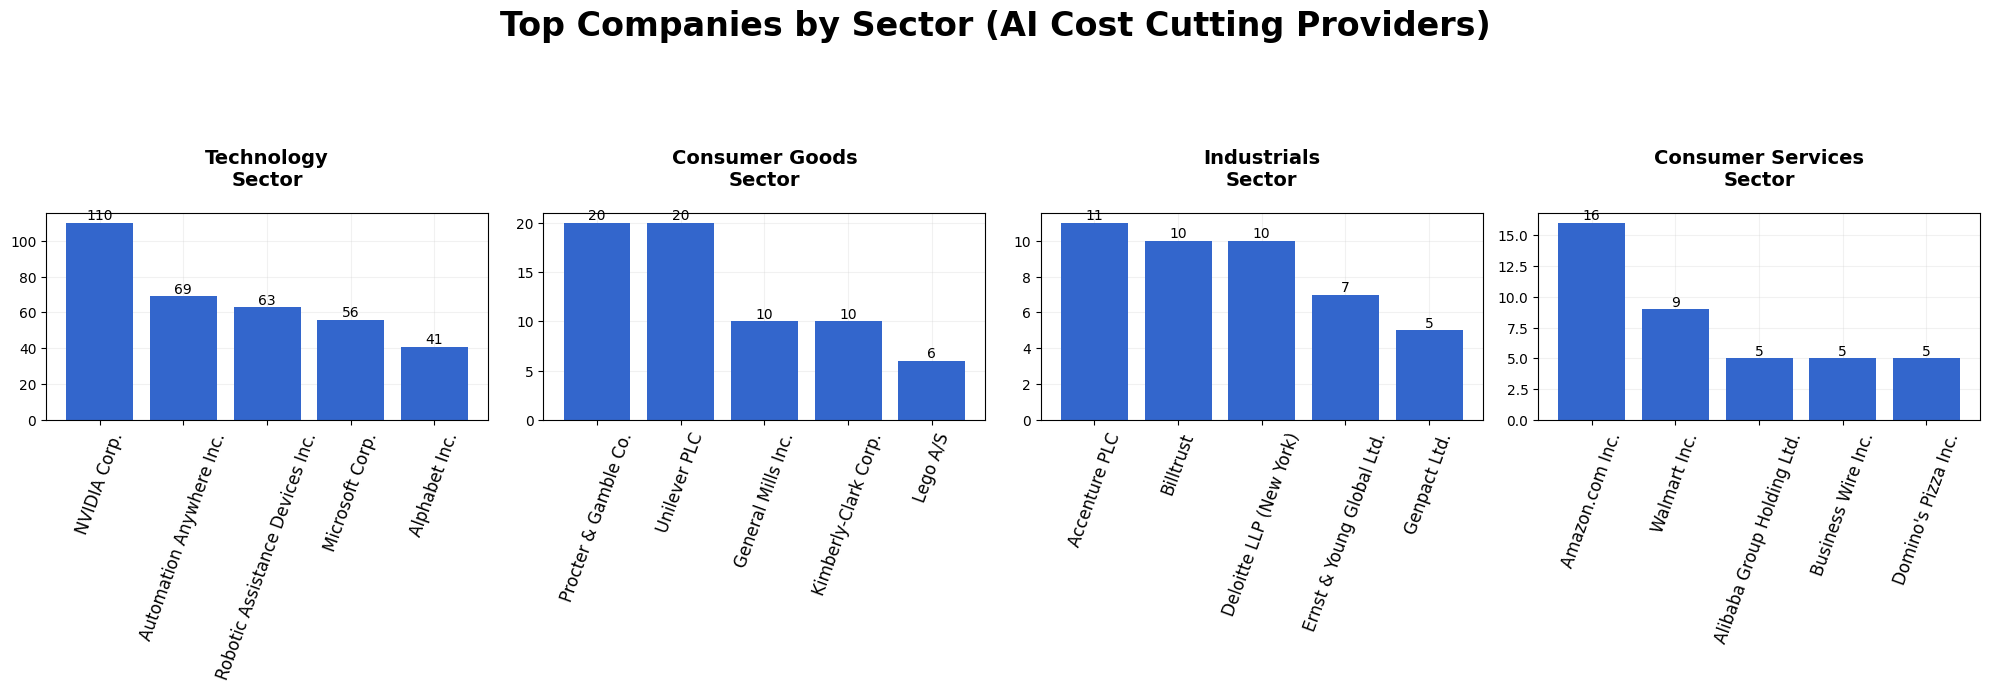

In [44]:
plot_top_companies_by_sector(df_providers, min_companies=1, title_suffix="(AI Cost Cutting Providers)", top_sectors=4, interactive=interactive_plots)

### Companies Using AI for Cost Cutting

This complementary chart shows companies most frequently mentioned as users of AI cost cutting technology in their operations, organized by sector and ranked by total mention volume. It identifies firms investing in AI automation, implementing cost reduction systems, or optimizing their operations through AI-driven efficiency improvements.

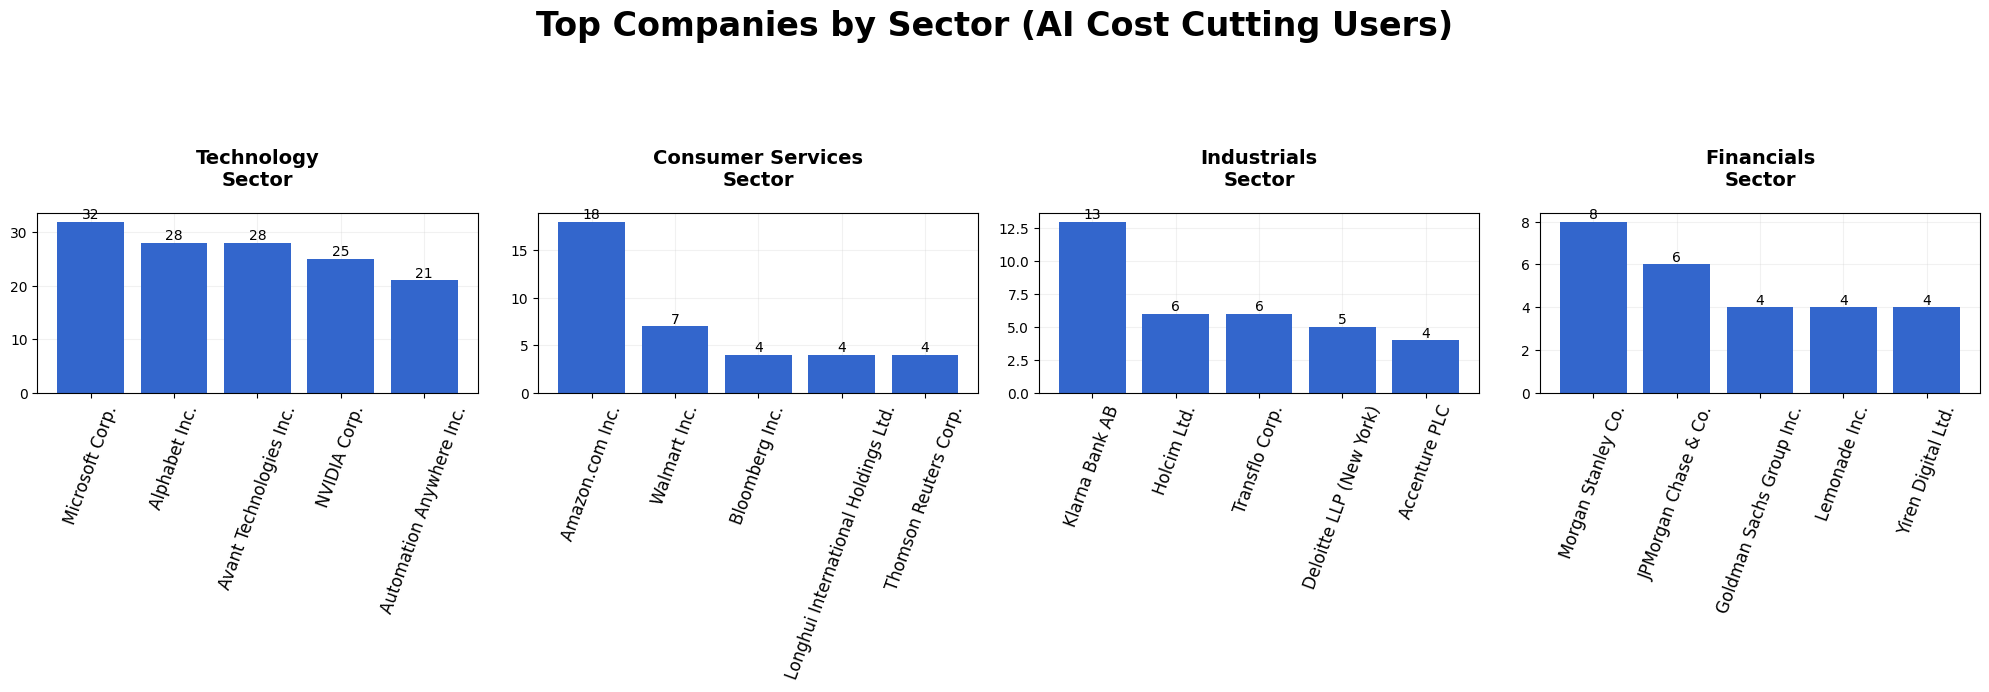

In [45]:
plot_top_companies_by_sector(df_users, min_companies=1, title_suffix="(AI Cost Cutting Users)", top_sectors=4, interactive=interactive_plots)

## AI Cost Cutting Ecosystem Analysis

This comprehensive assessment combines both provider and user signals to create a complete picture of the AI cost cutting ecosystem. The analysis provides:

- **Total Exposure**: Overall volume of AI cost cutting related news coverage for each company
- **Role Classification**: Relative proportion of provider versus user mentions  
- **Market Positioning**: How companies rank in terms of their involvement in the AI cost cutting market

The stacked bar chart shows the percentage breakdown of provider (green) versus user (red) mentions for the top 40 most-mentioned companies. Companies with predominantly blue bars are primarily technology providers, while those with green bars are mainly end-users implementing AI cost cutting solutions.

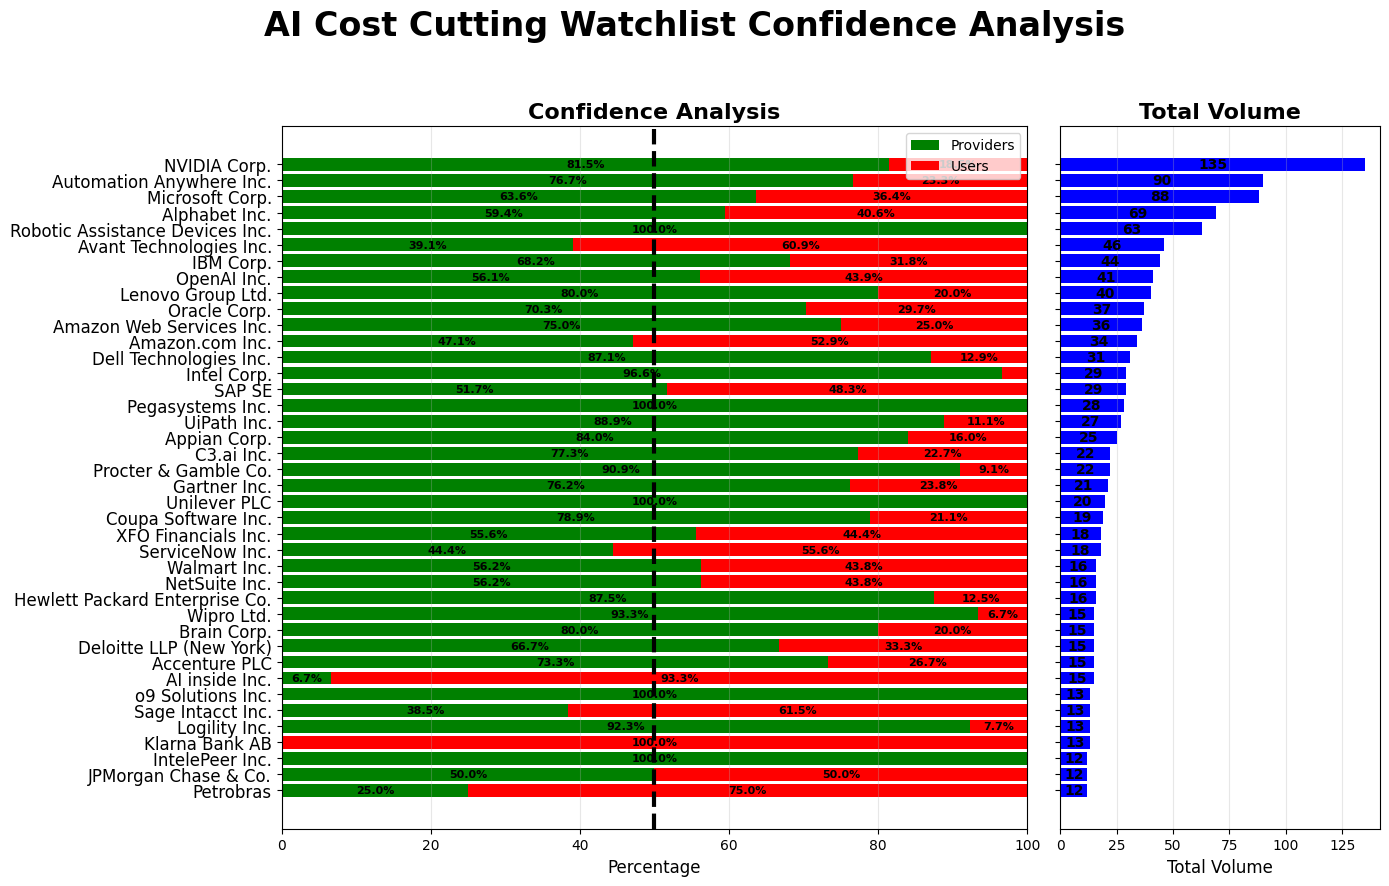

In [46]:
companies_basket = identify_basket_and_plot_confidence(df_providers,df_users, basket_size=40, theme_name='AI Cost Cutting', positive_label='Providers', negative_label='Users', interactive=interactive_plots)

In [24]:
companies_basket.head()

,Company,positive_exp,negative_exp,total_exposure,Sector,positive_exp_pct,negative_exp_pct,headline_positive_exp,text_positive_exp,motivation_positive_exp,headline_negative_exp,text_negative_exp,motivation_negative_exp
0,Petrobras,3.0,9.0,12.0,Energy,25.000000,75.000000,Automation Anywhere Exceeds First Quarter Targ...,Leveraging Google Cloud's Gemini models and Ve...,Petrobras provides GenAI solutions that improv...,Automation Anywhere's Generative AI-Powered Au...,After seeing its initial gains utilizing AI th...,Petrobras plans to leverage AI solutions to de...
1,JPMorgan Chase & Co.,6.0,6.0,12.0,Financials,50.000000,50.000000,TIFIN AMP's Industry-First Integrated Data Fab...,TIFIN is an AI and innovation platform for bet...,JPMorgan Chase & Co. is creating and operating...,"JPMorgan Aims for $1.5B in AI Value by 2023, B...",JPMorgan Chase & Co (NYSE:JPM) has significant...,JPMorgan Chase & Co. is using AI to significan...
2,IntelePeer Inc.,12.0,0.0,12.0,Technology,100.000000,0.000000,IntelePeer Integrates with Microsoft Azure Ope...,About IntelePeer IntelePeer simplifies communi...,IntelePeer Inc. provides advanced AI-powered s...,,,
3,Klarna Bank AB,0.0,13.0,13.0,Industrials,0.000000,100.000000,,,,Klarna using GenAI to cut marketing costs by $...,"STOCKHOLM (Reuters) - Fintech firm Klarna, one...",Klarna Bank AB is using AI for marketing campa...
4,Logility Inc.,12.0,1.0,13.0,Technology,92.307692,7.692308,American Software to Participate at the 24th B...,Logility is a market-leading provider of AI-fi...,Logility Inc. provides AI-first supply chain m...,American Software Reports Third Quarter of Fis...,Utilizing Industry 4.0 technologies such as ar...,Logility Inc. is utilizing AI and automation t...


## Top Companies Time Tracking

This visualization tracks the newsflow arrival across time for the top 4 companies most mentioned as users in AI cost cutting contexts, providing transparency about news content and media attention over time.

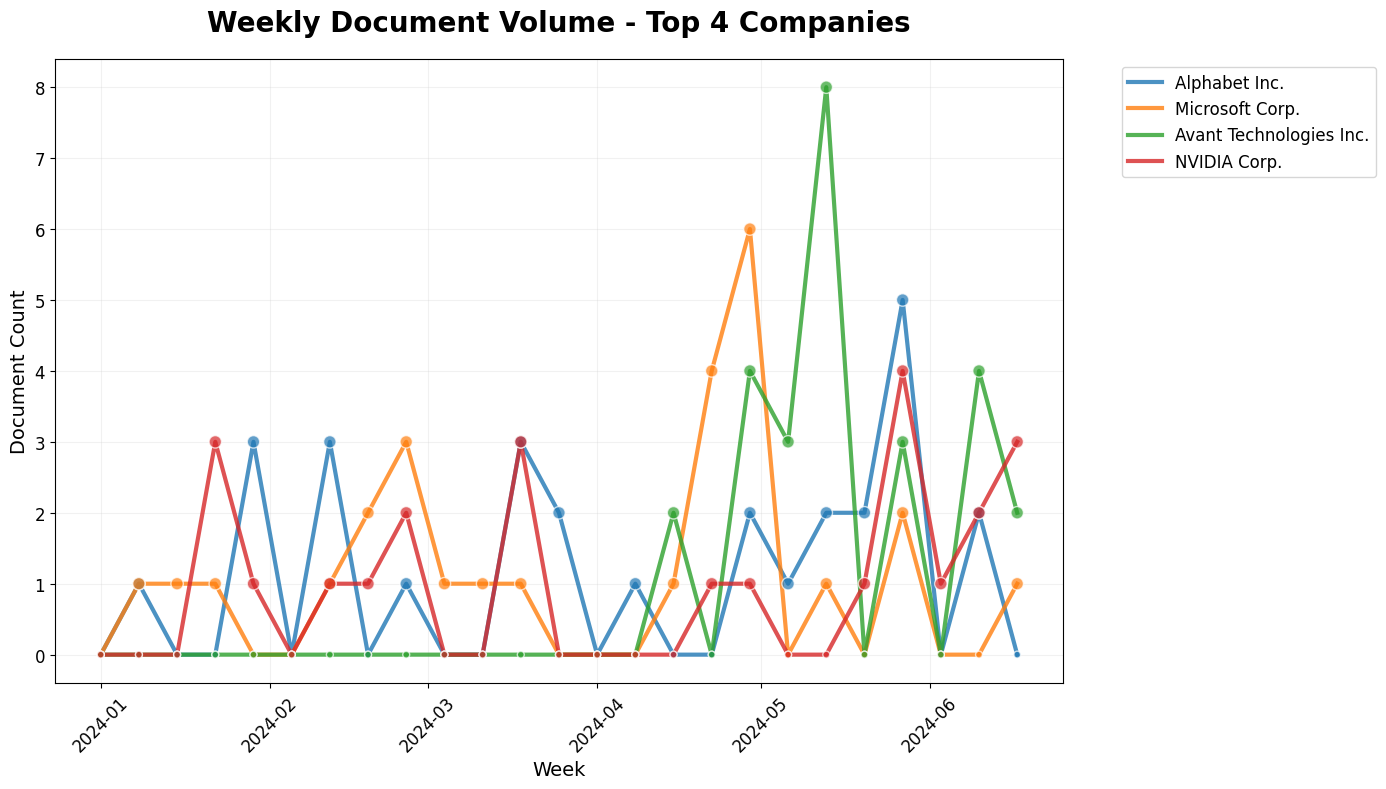

In [54]:
top_companies_time(df_users, interactive=interactive_plots)

## Provider-User Network Analysis

This network visualization reveals relationships between AI cost cutting technology providers and users through co-mentions in news articles. The analysis identifies:

- **Technology Partnerships**: Companies that frequently appear together in AI cost cutting contexts
- **Customer-Supplier Relationships**: Connections between solution providers and implementing organizations
- **Market Clusters**: Groups of companies operating in similar segments of the AI cost cutting ecosystem

Notable partnerships that may emerge include relationships between AI platform providers and enterprise users, automation vendors and operational teams, and technology developers working with early adopters to refine their cost cutting solutions.

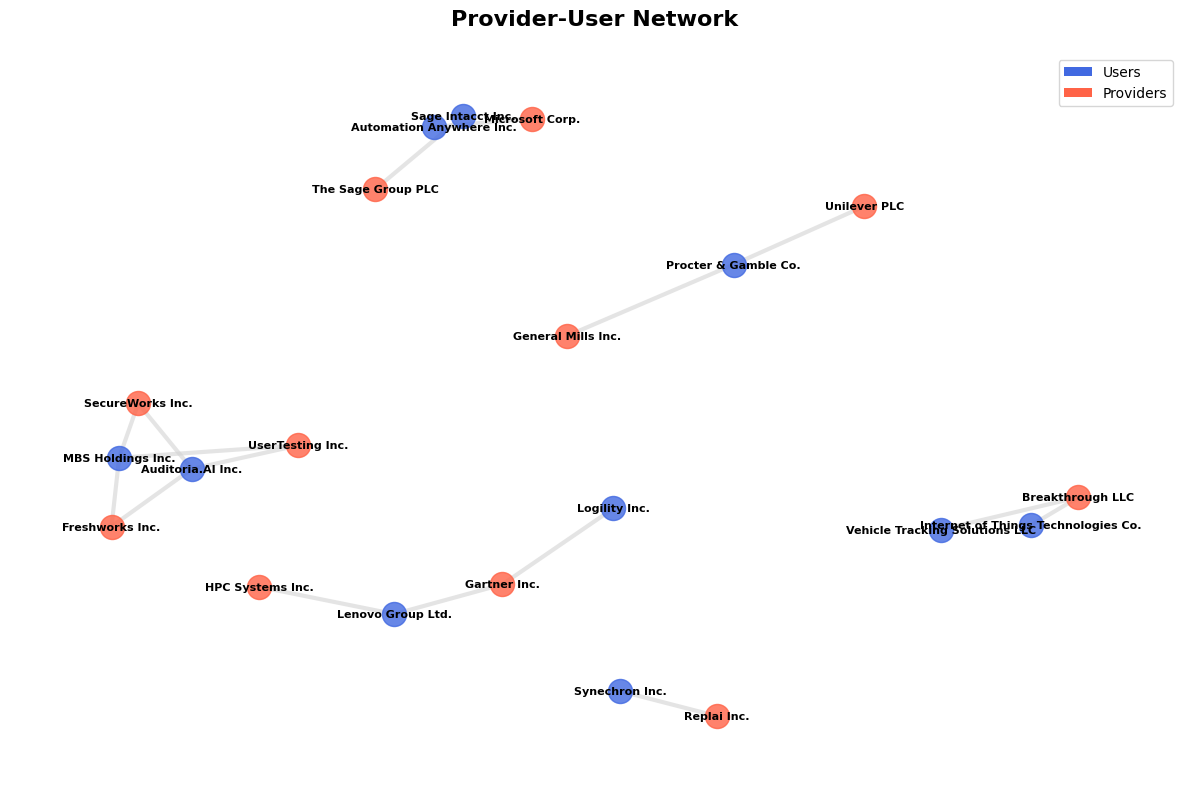

In [48]:
fig = provider_adopter_net(
    df_filtered_adopters=df_users,
    df_filtered_providers=df_providers,
    bigdata_cred=None,
    min_occurrences=1, # Change this if you want to see fewer companies in the network
    dash=False,
    interactive=interactive_plots
)

## Key Insights and Technology Stories

The AI cost cutting analysis reveals distinct sector-specific adoption patterns and technology leadership dynamics:

**Financial Services AI Implementation**: Morgan Stanley Co. emerges as the dominant user in the Financials sector, demonstrating how traditional financial institutions are rapidly adopting AI cost cutting solutions to streamline operations, automate processes, and enhance operational efficiency in an increasingly competitive landscape.

**Cross-Sector Technology Versatility**: Amazon.com Inc. stands out in the Consumer sector as a unique dual-role player, simultaneously serving as both a leading provider of AI cost cutting solutions and a major implementer of these technologies in its own operations, showcasing the company's comprehensive AI ecosystem strategy.

**Technology Sector Innovation Hub**: The Technology sector reveals a clear hierarchy with NVIDIA leading as the primary provider of AI cost cutting infrastructure, while Microsoft and Alphabet dominate the broader provider landscape, reflecting their strategic positioning in enterprise AI solutions and cloud-based cost optimization platforms.

**Industrial Sector Digital Transformation**: Klarna Bank AB's prominence in the Industrials sector highlights the broader trend of fintech and digital-first companies driving AI adoption within traditionally industrial classifications, indicating how sector boundaries are evolving with digital transformation.

## Export the Results

Export the data as Excel files for further analysis or to share with the team.

In [27]:
try:
    # Create the Excel manager
    excel_manager = ExcelManager()

    # Define the dataframes and their sheet configurations
    df_args = [
        (df_providers, "AI Cost Cutting Providers", (0, 0)),
        (df_users, "AI Cost Cutting Users", (0, 0)),
        (companies_basket, "Technology Ecosystem Basket", (2, 4)),
    ]

    # Save the workbook
    excel_manager.save_workbook(df_args, export_path)
    print(f"✅ Results exported to {export_path}")

except Exception as e:
    print(f"Warning while exporting to excel: {e}")

✅ Results exported to output/ai_cost_cutting_analysis_results.xlsx


In [21]:
print("Runtime:", datetime.datetime.now() - start)

Runtime: 0:04:06.299391
